In [5]:
import numpy as np
import pandas as pd
from scipy import signal
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid 
import pathlib
from pathlib import Path
from Utils import SpEC_utils as spu
import cmcrameri.cm as cmc  #scientific color maps - perceptually uniform
import numpy as np


In [6]:
#Q_all.diff(axis=0).multiply(0.01).cumsum(axis=0).sum(axis=1).plot()
#calculate_J_cap(Q_all=Q_all,scan_rate=scan_rate).cumsum(axis=0).divide(scan_rate).plot()

In [7]:
#plt.plot(t[t>60]-60,str_exp_dec(t[t>60]-60, a=0.0298,b=0.01).cumsum())

(50, 3) (3, 700)


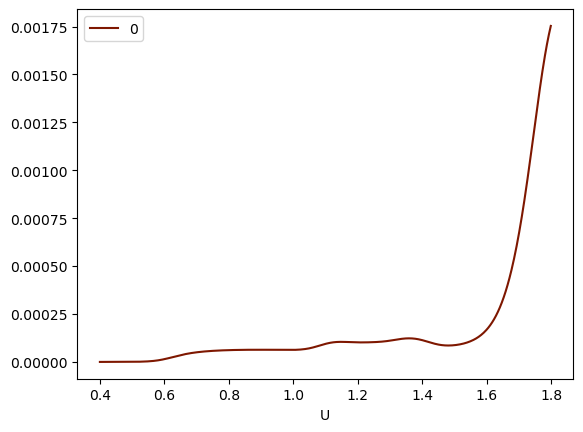

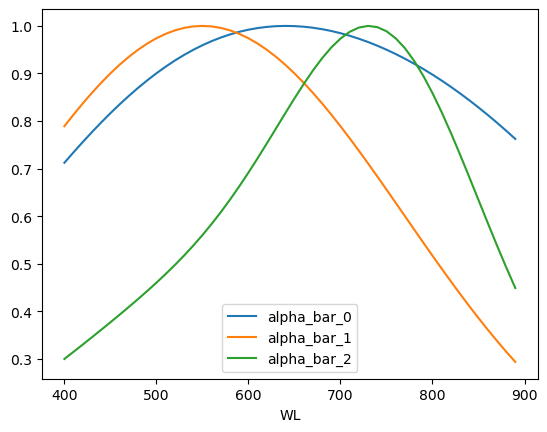

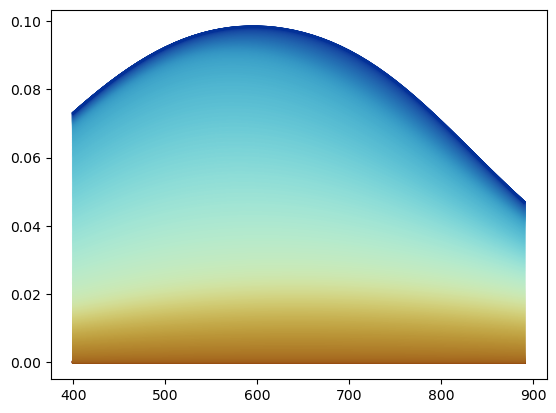

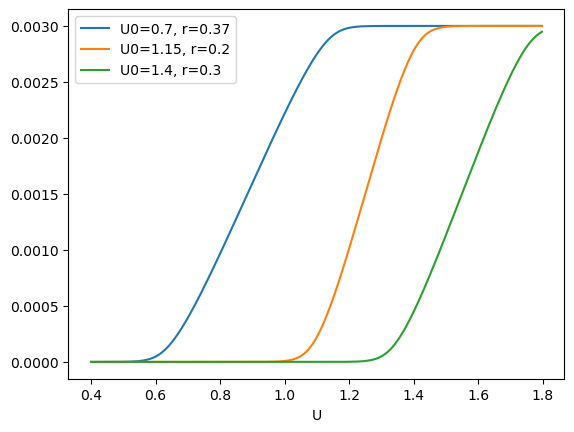

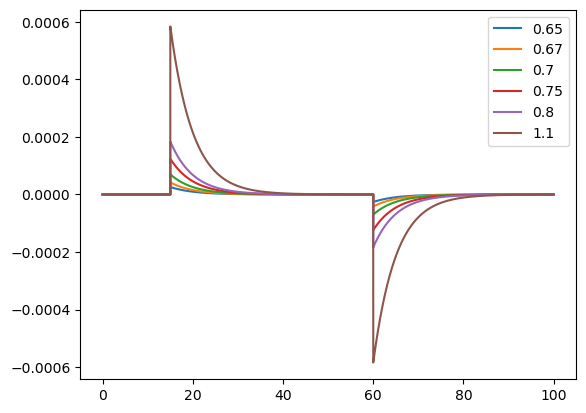

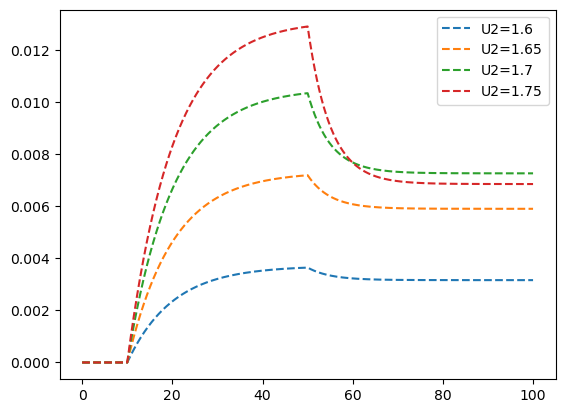

In [8]:
if __name__ == "__main__":

    #1. Define the parameters for SpEC
    E=np.arange(0.4,1.8,0.002) # here is the E aray we use to calculate the theta values from the frumkin equation
    # for nice plots later keep the upper limit of E about 0.5 V more than E02 (note this will depend on the r value that you choose)
    E0_l=[0.7,1.15,1.4] # list of standard potentials
    r_l=[0.37,0.2,0.3] # list of itneraction enthalpies in eV
    WLs=np.arange(400,900,10) # Wavelengths
    mu_all=[[450,900,650],[450,550,650],[550,700,750]] # list of mu values for the gaussian peaks
    sigma_all=[[200,200,200],[200,200,200],[200,200,100]] # list of sigma values for the gaussian peaks
    alphas=[10,20,5]# these are the peak values of Delta alpha for each component in units of Delta OD
    Q_max_all=[0.003,0.003,0.003]# the maximum Q values for each component in units of C/cm^2
    scan_rate=0.01

    # define the parameters for the SW-SpEC
    t=np.arange(0, 100, 0.01) # this defines the time resolution of the measurment
    b1=0.2 # this is the rate constant for the exponential function that models the chaginf transient - note the real function is not exponential but this is a nice approximation
    t1=15 # this is the time at which U2 is applied
    t2=60 # this is the time at which U1 is applied


    #3. calculate the fundamental parameters for the SpEC

    all_thetas=spu.calcualte_all_thetas(U=E, U0_l=E0_l, r_l=r_l)
    all_alpha_bar=spu.generate_alpha_bar_spectra(WLs, mu_all, sigma_all)
    Q_all=spu.calculate_Q(all_thetas, Q_max_all)
    J_total=spu.calculate_current(all_thetas, Q_max_all, scan_rate=scan_rate)
    JBEP=spu.calculate_BEP_cat_current(all_thetas)
    J_cap=spu.calculate_J_cap(Q_all, scan_rate=scan_rate)
    J_total.plot(colormap=cmc.roma)

    # calcaulte the SpEC
    SpEC=spu.generate_SpEC(WLs, E, all_alpha_bar, all_thetas, Q_max_all, alphas)

    all_alpha_bar.plot()  
    SpEC.plot(colormap=cmc.roma, legend=False)
    Q_all.plot()


    #4 calculate the SW-SpEC
    SW_U2_list=[0.65, 0.67, 0.7, 0.75, 0.8, 1.1] # note 1.1 is purposley chosen to be a mixture so you can see the difference between the SW-SpEC and the PD-SpEC

    SW_SpECdict={}
    for U2 in SW_U2_list:
        SW_SpECdict[U2]=spu.SW_SpEC(SpEC=SpEC, U1=0.6, U2=U2, Q_all=Q_all, t=t, b=b1, t1=t1, t2=t2)
        SW_SpECdict[U2].index=WLs.flatten()
        SW_SpECdict[U2].columns=t
        
    # then the equivalent current for each U2

    J_SW_dict={}
    for U2 in SW_U2_list:
        J_SW_dict[U2]=spu.PW_J_for_U1_U2(U1=0.6, U2=U2, Q_all=Q_all, t=t, b=b1, t1=t1, t2=t2).values.flatten()
    J_all=pd.DataFrame(J_SW_dict)

    # pack all Js into a dataframe with titles of U1 and U2
    J_all.index=t



    

    # plot the J as a new fig, ax
    fig2, ax2 = plt.subplots()
    J_all.plot(ax=ax2)

    # generate the charge and current for the PD dynamics
    U1=1.55
    U2_array=np.arange(1.6,1.8,0.05)
    PD_dyn={}
    for U2 in U2_array:
        PD_dyn[U2]=spu.calculate_PD_dynamics_at_U2(U2, U1, all_thetas, Q_all, t, b=0.1, b1=1, t1=10, t2=50)

    PD_slow=spu.calculate_PD_dynamics_at_U2(1.6,1.55, all_thetas, Q_all, t, b=0.1, b1=1000, t1=10, t2=50)

    # Slow decaying dynamics are not modelled well by calculate_PD_dynamics_at_U2. I could have modelled this with a very slow linear
    # decay function but realistic dynamics are so slow it it simpler to just ramp up b1 so the the decaying amplitude of the power law goes to zero
    # this models product of an equilibrium which does not react. Please ignore the voltages 1.6 and 1.55  - they do not matter as the resulting spectrum
    # is going to be nromalised but the function is made to match rates with the current dynamics so in a region with no current the fucntion fails to evaluate
    # properly. This is a work around to avoid writting excessive code to model a simple case.

    fig3, ax3 = plt.subplots()
    i = 0
    for U2, (t, PDQt, PDJt) in PD_dyn.items():
        ax3.plot(t, PDQt, linestyle='--', label=f'U2={np.round(U2_array[i], 3)}')
        i += 1
    ax3.legend()

    PD_J_dyn=pd.DataFrame()
    for U2, (t, PDQt, PDJt) in PD_dyn.items():
        PD_J_dyn[U2]=PDJt
    PD_J_dyn.index=t

    
        

    # calcaulte the PD spectral dynamics

    PD_spectra={}
    for U2 in U2_array:
        PD_spectra[U2]=spu.PD_SpEC(SpEC=SpEC, U1=U1, U2=U2, all_thetas=all_thetas, Q_all=Q_all, t=t, b=0.1, b1=1, t1=10, t2=50)




    


    
    
    


   

    


In [9]:
PD_J_dyn

,1.60,1.65,1.70,1.75
0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0.01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0.02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0.03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0.04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...
99.95,-4.431453e-09,-1.184664e-08,-2.830068e-08,-5.561784e-08
99.96,-4.422599e-09,-1.182297e-08,-2.824414e-08,-5.550672e-08
99.97,-4.413763e-09,-1.179935e-08,-2.818771e-08,-5.539581e-08
99.98,-4.404944e-09,-1.177577e-08,-2.813139e-08,-5.528513e-08


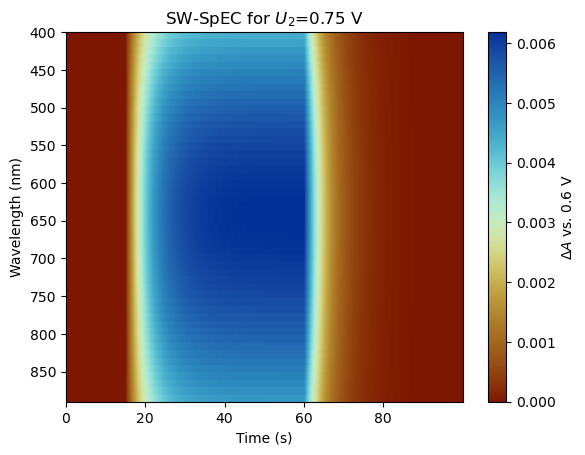

In [10]:
SW_SpECdict[SW_U2_list[3]].index=WLs.flatten()

index_values = WLs.flatten()  # Replace with your actual index values
column_values = t  # Replace with your actual column values
plt.imshow(SW_SpECdict[SW_U2_list[3]], aspect='auto', cmap=cmc.roma, interpolation='nearest', extent=[column_values.min(), column_values.max(), index_values[-1], index_values[0]])
plt.yticks(ticks=index_values[::5], labels=index_values[::5])
plt.colorbar(label=rf'$\Delta A$ vs. 0.6 V')
# set the y axis name to Wavelength (nm)
plt.ylabel('Wavelength (nm)')
plt.xlabel('Time (s)')
plt.title(f'SW-SpEC for $U_2$={SW_U2_list[3]} V')
plt.show()


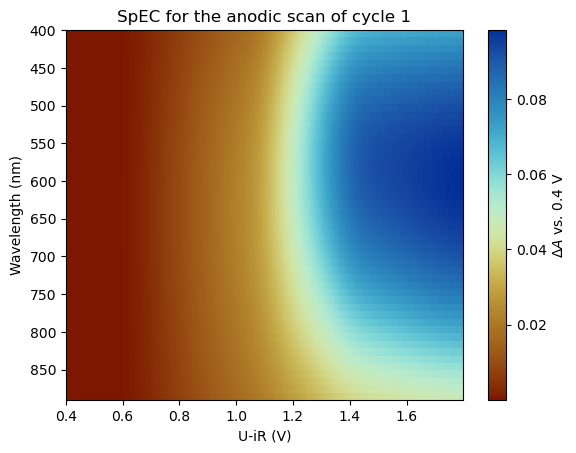

In [11]:
# apply the same imshow code to the SpEC
index_values = WLs.flatten()  # Replace with your actual index values
column_values = E  # Replace with your actual column values
plt.imshow(SpEC, aspect='auto', cmap=cmc.roma, interpolation='nearest', extent=[column_values.min(), column_values.max(), index_values[-1], index_values[0]])
plt.yticks(ticks=index_values[::5], labels=index_values[::5])
plt.colorbar(label=rf'$\Delta A$ vs. {SpEC.columns.values.min()} V')
# set the y axis name to Wavelength (nm)
plt.ylabel('Wavelength (nm)')
plt.xlabel('U-iR (V)')

plt.title(f'SpEC for the anodic scan of cycle 1')
plt.show()


<>:8: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\D'
/var/folders/vm/d986p9hx0rlglk34b43v_h180000gn/T/ipykernel_18692/2352506484.py:8: SyntaxWarning: invalid escape sequence '\D'
  plt.colorbar(label=f'$\Delta A$ vs. {U1} V')


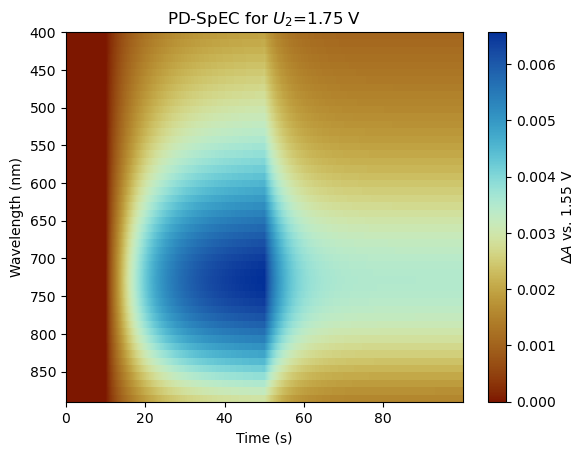

In [12]:
PD_spec3=PD_spectra[U2_array[3]]

# apply the same imshow code to the PD_spec3
index_values = WLs.flatten()  # Replace with your actual index values
column_values = t  # Replace with your actual column values
plt.imshow(PD_spec3, aspect='auto', cmap=cmc.roma, interpolation='nearest', extent=[column_values.min(), column_values.max(), index_values[-1], index_values[0]])
plt.yticks(ticks=index_values[::5], labels=index_values[::5])
plt.colorbar(label=f'$\Delta A$ vs. {U1} V')
# set the y axis name to Wavelength (nm)
plt.ylabel('Wavelength (nm)')
plt.xlabel('Time (s)')
plt.title(f'PD-SpEC for $U_2$={np.round(U2_array[3],3)} V')
plt.show()

In [43]:
from pathlib import Path

# Get the path of the folder 'Data' which is located in the parent directory of the current directory
path = Path.cwd().joinpath('Data')

SpEC.to_parquet(path.joinpath('SpEC.parquet'))
all_thetas.to_parquet(path.joinpath('thetas_ground_truth.parquet'))
Q_all.to_parquet(path.joinpath('Q_all_ground_truth.parquet'))
J_total.to_parquet(path.joinpath('J_SpEC.parquet'))
J_cap.to_parquet(path.joinpath('J_cap_SpEC.parquet'))
JBEP.to_parquet(path.joinpath('J_BEP_SpEC.parquet'))
J_all.to_parquet(path.joinpath('J_SW_all.parquet'))
all_thetas.to_parquet(path.joinpath('all_thetas_ground_truth.parquet'))
for name, df in SW_SpECdict.items():
    df.to_parquet(path.joinpath(f'SW_SpEC_{name}.parquet'))



pd.DataFrame(PD_slow[1]/PD_slow[1].max(), index=t).to_parquet(path.joinpath('PD_slow.parquet'))


dyn_dict={}
for name, tup in PD_dyn.items():
    time=tup[0]
    A=tup[1]
    dyn_dict[name]=A

pd.DataFrame(dyn_dict, index=t).to_parquet(path.joinpath('PD_dyn.parquet'))

    